In [1]:
from sklearn import datasets
%matplotlib inline 
#so that the plot will be displayed in the notebook
import numpy as np
np.random.seed(42)

import matplotlib
from matplotlib import pyplot as plt


digits = datasets.load_digits()
list(digits.keys())

['data', 'target', 'target_names', 'images', 'DESCR']

In [2]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

In [3]:
X, y = digits["data"], digits["target"]
X.shape

(1797, 64)

In [4]:
y.shape

(1797,)

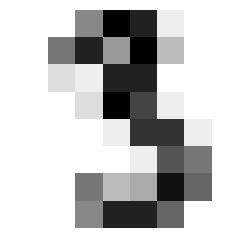

In [5]:
some_digit = X[3]
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[3]

3

For the rest of the practical, apply the data preprocessing techniques, implement and evaluate the classification models on the digits dataset using the steps that you applied above to the iris dataset.

## Splitting the data into training and test subsets

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split.get_n_splits(X, y)
print(split)       

for train_index, test_index in split.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
TRAIN: 1437 TEST: 360
(1437, 64) (1437,) (360, 64) (360,)


In [8]:
import pandas as pd

# def original_proportions(data):
#     props = {}
#     for value in set(data["target"]):
#         data_value = [i for i in data["target"] if i==value]
#         props[value] = len(data_value) / len(data["target"])
#     return props

def subset_proportions(subset):
    props = {}
    for value in set(subset):
        data_value = [i for i in subset if i==value]
        props[value] = len(data_value) / len(subset)
    return props

   
compare_props = pd.DataFrame({
    "Overall": subset_proportions(digits["target"]),
    "Stratified tr": subset_proportions(y_train),
    "Stratified ts": subset_proportions(y_test),
})
compare_props["Strat. tr %error"] = 100 * compare_props["Stratified tr"] / compare_props["Overall"] - 100
compare_props["Strat. ts %error"] = 100 * compare_props["Stratified ts"] / compare_props["Overall"] - 100

compare_props.sort_index()

,Overall,Stratified tr,Stratified ts,Strat. tr %error,Strat. ts %error
0,0.099054,0.098817,0.100000,-0.239263,0.955056
1,0.101280,0.101601,0.100000,0.316594,-1.263736
2,0.098497,0.098817,0.097222,0.324357,-1.294727
3,0.101836,0.101601,0.102778,-0.231584,0.924408
4,0.100723,0.100905,0.100000,0.179933,-0.718232
5,0.101280,0.100905,0.102778,-0.370506,1.478938
6,0.100723,0.100905,0.100000,0.179933,-0.718232
7,0.099610,0.099513,0.100000,-0.097969,0.391061
8,0.096828,0.096729,0.097222,-0.101984,0.407088
9,0.100167,0.100209,0.100000,0.041754,-0.166667


## Case 1: Binary classification

In [9]:
y_train_zero = (y_train == 0) # will return True when the label is 0 (i.e., digit labelled zero)
y_test_zero = (y_test == 0)

y_train_one = (y_train == 1)
y_test_one = (y_test == 1)

y_train_four = (y_train == 4)
y_test_four = (y_test == 4)

y_train_eight = (y_train == 8)
y_test_eight = (y_test == 8)

In [10]:
zero_example = X_test[10]
zero_example

array([ 0.,  0.,  4., 16., 16.,  4.,  0.,  0.,  0.,  0., 10., 15., 12.,
       14.,  0.,  0.,  0.,  2., 11.,  0.,  0.,  9.,  6.,  0.,  0.,  5.,
        6.,  0.,  0.,  4.,  5.,  0.,  0.,  4.,  9.,  0.,  0.,  7.,  4.,
        0.,  0.,  4., 10.,  0.,  2., 14.,  0.,  0.,  0.,  0., 14., 15.,
       16.,  8.,  0.,  0.,  0.,  0.,  4., 13., 10.,  0.,  0.,  0.])

### Perceptron

In [11]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=5, tol=None, random_state=42,
                   loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
sgd.fit(X_train, y_train)
sgd.predict([zero_example])

array([0])

In [12]:
def test_classifier_for_each_digit(classifier):
    for i in range(10):
        y_train_value = (y_train == i)
        y_test_value = (y_test == i)
        value_trues = [j for j in range(len(y_test_value)) if y_test_value[j] == True]
        value_example = X_test[value_trues[0]]
        classifier.fit(X_train,y_train_value)
        some_digit_image = value_example.reshape(8, 8)
        #print(some_digit_image)
        print("Is it the value {}? ".format(i),end='')
        print(classifier.predict([value_example])[0])
    
test_classifier_for_each_digit(sgd)

Is it the value 0? True
Is it the value 1? True
Is it the value 2? True
Is it the value 3? True
Is it the value 4? False
Is it the value 5? True
Is it the value 6? True
Is it the value 7? True
Is it the value 8? False
Is it the value 9? True


Therefore predicted fairly well, only getting the first examples of 4 and 8 incorrect.

### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
test_classifier_for_each_digit(log_reg)

Is it the value 0? True
Is it the value 1? False
Is it the value 2? True
Is it the value 3? True
Is it the value 4? True
Is it the value 5? True
Is it the value 6? True
Is it the value 7? True
Is it the value 8? False
Is it the value 9? True


Therefore also predicted fairly well, only getting the first examples of 1 and 8 incorrect. These results are implying that the first occurence of an 8-labelled digit is either fairly difficult to classify, or 8 itself is a harder one to classify.

### Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

mnb = MultinomialNB() # or:
gnb = GaussianNB() 

test_classifier_for_each_digit(mnb)

Is it the value 0? True
Is it the value 1? True
Is it the value 2? True
Is it the value 3? True
Is it the value 4? True
Is it the value 5? True
Is it the value 6? True
Is it the value 7? True
Is it the value 8? True
Is it the value 9? True


In [15]:
test_classifier_for_each_digit(gnb)

Is it the value 0? True
Is it the value 1? True
Is it the value 2? True
Is it the value 3? True
Is it the value 4? True
Is it the value 5? True
Is it the value 6? True
Is it the value 7? True
Is it the value 8? True
Is it the value 9? True


This implies this predictor is potentially performing better. However we need to look into results in more detail to ensure this isn't caused by also having many False Positives.

## Evaluation

In [16]:
from sklearn.model_selection import cross_val_score

def get_cross_val_score_for_value(value,classifiers):
    y_train_value = (y_train == value)
    for classifier in classifiers:
        print(np.mean(cross_val_score(classifier, X_train, y_train_value, cv=5, scoring="accuracy")))
    
for i in range(10):
    print(i)
    get_cross_val_score_for_value(i,[log_reg,gnb,sgd])

0
0.9993055555555556
0.9923465931087883
0.996525358110724
1
0.9700637787396165
0.6068215521502719
0.9666132163051735
2
1.0
0.7356029810298103
0.9937354819976771
3
0.9798150537115852
0.6583846738121361
0.9588946625996165
4
0.997212543554007
0.8413714672861013
0.9951292102206738
5
0.9888646922183508
0.5407907471931862
0.9777342237708091
6
0.9937306426635695
0.9387679055361982
0.988862272551297
7
0.9923417030124349
0.8357837453874039
0.9944298756798757
8
0.9526637826942705
0.5177701871299432
0.8824035381962212
9
0.9728657690547934
0.7146786479103553
0.9172399077886884


A few conclusions from these results:
The Logistic Regression and Perceptron classifiers commonly perform better.

The numbers 0,1,2,4,5,6 and 7 seem far easier to predict than 3, 8 and 9. Especially 8, with one of the cross validation scores with the Perceptron classifier being very low at 0.7.

To give these values some more context, let's build a "always predict not value" classifier and get its accuracy for each value.

In [17]:
from sklearn.base import BaseEstimator

class NotXClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
notX_clf = NotXClassifier()
for i in range(10):
    print(i)
    get_cross_val_score_for_value(i,[notX_clf])
#cross_val_score(notX_clf, X_train, y_train_zero, cv=5, scoring="accuracy")

0
0.9011977351916377
1
0.8984247967479675
2
0.9011759581881533
3
0.8984078590785908
4
0.8991071428571429
5
0.8990732675183896
6
0.8990950445218738
7
0.9004766744096013
8
0.9032617111885404
9
0.8997798102981029


### Confusion matrix

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(value):
    y_train_value = (y_train == value)
    y_train_pred_log_reg = cross_val_predict(log_reg, X_train, y_train_value, cv=5)
    print("Logistic Regression - {}:".format(value))
    print(confusion_matrix(y_train_value, y_train_pred_log_reg))
    
    y_train_pred_sgd = cross_val_predict(sgd, X_train, y_train_value, cv=5)
    print("Perceptron - {}:".format(value))
    print(confusion_matrix(y_train_value, y_train_pred_sgd))
    
    y_train_pred_gnb = cross_val_predict(gnb, X_train, y_train_value, cv=5)
    print("Naive Bayes - {}:".format(value))
    print(confusion_matrix(y_train_value, y_train_pred_gnb))

for i in range(10):
    get_confusion_matrix(i)

Logistic Regression - 0:
[[1295    0]
 [   1  141]]
Perceptron - 0:
[[1292    3]
 [   2  140]]
Naive Bayes - 0:
[[1286    9]
 [   2  140]]
Logistic Regression - 1:
[[1265   26]
 [  17  129]]
Perceptron - 1:
[[1256   35]
 [  13  133]]
Naive Bayes - 1:
[[728 563]
 [  2 144]]
Logistic Regression - 2:
[[1295    0]
 [   0  142]]
Perceptron - 2:
[[1292    3]
 [   6  136]]
Naive Bayes - 2:
[[923 372]
 [  8 134]]
Logistic Regression - 3:
[[1273   18]
 [  11  135]]
Perceptron - 3:
[[1269   22]
 [  37  109]]
Naive Bayes - 3:
[[804 487]
 [  4 142]]
Logistic Regression - 4:
[[1291    1]
 [   3  142]]
Perceptron - 4:
[[1289    3]
 [   4  141]]
Naive Bayes - 4:
[[1070  222]
 [   6  139]]
Logistic Regression - 5:
[[1284    8]
 [   8  137]]
Perceptron - 5:
[[1277   15]
 [  17  128]]
Naive Bayes - 5:
[[637 655]
 [  5 140]]
Logistic Regression - 6:
[[1287    5]
 [   4  141]]
Perceptron - 6:
[[1289    3]
 [  13  132]]
Naive Bayes - 6:
[[1206   86]
 [   2  143]]
Logistic Regression - 7:
[[1288    6]
 [   

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_precision_recall_f1_scores(value):
    print(value)
    y_train_value = (y_train == value)
    y_train_pred_log_reg = cross_val_predict(log_reg, X_train, y_train_value, cv=5)
    precision = precision_score(y_train_value, y_train_pred_log_reg)
    recall = recall_score(y_train_value, y_train_pred_log_reg)
    f1 = f1_score(y_train_value, y_train_pred_log_reg)
    print("Logistic Regression")
    print("Precision: {}, Recall: {}, F1 Score: {}".format(precision, recall, f1))
    
    y_train_pred_sgd = cross_val_predict(sgd, X_train, y_train_value, cv=5)
    precision = precision_score(y_train_value, y_train_pred_sgd)
    recall = recall_score(y_train_value, y_train_pred_sgd)
    f1 = f1_score(y_train_value, y_train_pred_sgd)
    print("Perceptron")
    print("Precision: {}, Recall: {}, F1 Score: {}".format(precision, recall, f1))
    
    y_train_pred_gnb = cross_val_predict(gnb, X_train, y_train_value, cv=5)
    precision = precision_score(y_train_value, y_train_pred_gnb)
    recall = recall_score(y_train_value, y_train_pred_gnb)
    f1 = f1_score(y_train_value, y_train_pred_gnb)
    print("Naive Bayes")
    print("Precision: {}, Recall: {}, F1 Score: {}".format(precision, recall, f1))
    print()
    
for i in range(10):
    get_precision_recall_f1_scores(i)

0
Logistic Regression
Precision: 1.0, Recall: 0.9929577464788732, F1 Score: 0.9964664310954063
Perceptron
Precision: 0.9790209790209791, Recall: 0.9859154929577465, F1 Score: 0.9824561403508772
Naive Bayes
Precision: 0.9395973154362416, Recall: 0.9859154929577465, F1 Score: 0.9621993127147765

1
Logistic Regression
Precision: 0.832258064516129, Recall: 0.8835616438356164, F1 Score: 0.8571428571428571
Perceptron
Precision: 0.7916666666666666, Recall: 0.910958904109589, F1 Score: 0.8471337579617834
Naive Bayes
Precision: 0.2036775106082037, Recall: 0.9863013698630136, F1 Score: 0.33763188745603756

2
Logistic Regression
Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Perceptron
Precision: 0.9784172661870504, Recall: 0.9577464788732394, F1 Score: 0.9679715302491103
Naive Bayes
Precision: 0.2648221343873518, Recall: 0.9436619718309859, F1 Score: 0.4135802469135803

3
Logistic Regression
Precision: 0.8823529411764706, Recall: 0.9246575342465754, F1 Score: 0.9030100334448161
Perceptron
Precision:

### Precision-recall trade-off

[-10.26200358  -6.45744502 -14.32362923 ...  -2.82403579 -19.71333142
  -8.5243048 ]


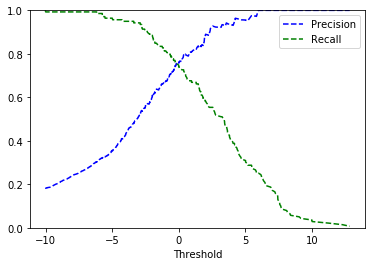

In [20]:
from sklearn.metrics import precision_recall_curve
y_train_eight = (y_train == 8) 
y_scores = cross_val_predict(log_reg, X_train, y_train_eight, cv=5, method="decision_function")
print(y_scores)
precisions, recalls, thresholds = precision_recall_curve(y_train_eight, y_scores)

def plot_pr_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper right")
    plt.ylim([0, 1])
    
plot_pr_vs_threshold(precisions, recalls, thresholds)
plt.show()

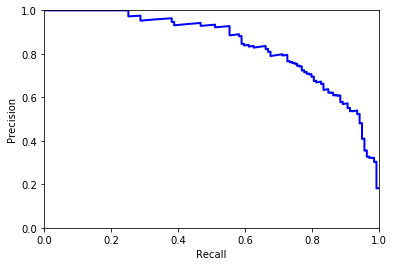

In [21]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

### The Receiver Operating Characteristic (ROC)

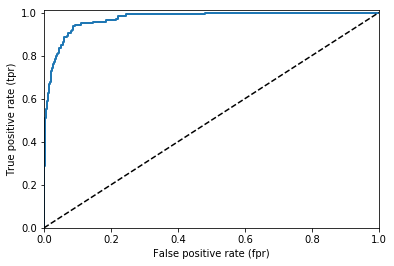

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_eight, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1.01])
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_eight, y_scores)

0.9725864916695304

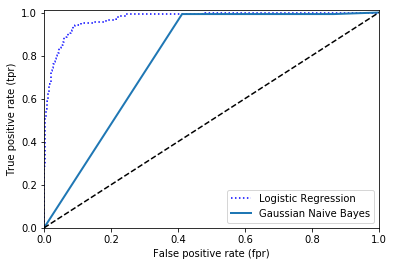

In [24]:
y_probas_gnb = cross_val_predict(gnb, X_train, y_train_eight, cv=3, method="predict_proba")
y_scores_gnb = y_probas_gnb[:, 1] # score = proba of the positive class
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_train_eight, y_scores_gnb)

plt.plot(fpr, tpr, "b:", label="Logistic Regression")
plot_roc_curve(fpr_gnb, tpr_gnb, "Gaussian Naive Bayes")
plt.legend(loc="lower right")
plt.show()

In [25]:
roc_auc_score(y_train_eight, y_scores_gnb)

0.7886870780725189

## Step 4: Data Transformations

### Kernel Trick

In [28]:
from sklearn.kernel_approximation import RBFSampler
y_train_example = y_train_one

rbf_features = RBFSampler(gamma=1, random_state=42)
X_train_features = rbf_features.fit_transform(X_train)
print(X_train.shape, "->", X_train_features.shape)
sgd_rbf = SGDClassifier(max_iter=5, random_state=42, loss="perceptron", 
                        eta0=1, learning_rate="constant", penalty=None)
sgd_rbf.fit(X_train_features, y_train_example) 

sgd_rbf.score(X_train_features, y_train_example)

(1437, 64) -> (1437, 100)


0.546276965901183

In [29]:
y_train_pred = cross_val_predict(sgd, X_train, y_train_example, cv=5)
precision = precision_score(y_train_example, y_train_pred)
recall = recall_score(y_train_example, y_train_pred)
f1 = f1_score(y_train_example, y_train_pred)
print(confusion_matrix(y_train_example,y_train_pred))
print(precision, recall, f1)

y_train_pred = cross_val_predict(sgd_rbf, X_train_features, y_train_example, cv=5)
precision = precision_score(y_train_example, y_train_pred)
recall = recall_score(y_train_example, y_train_pred)
f1 = f1_score(y_train_example, y_train_pred)
print(confusion_matrix(y_train_example,y_train_pred))
print(precision, recall, f1)

[[1256   35]
 [  13  133]]
0.7916666666666666 0.910958904109589 0.8471337579617834
[[1182  109]
 [ 131   15]]
0.12096774193548387 0.10273972602739725 0.1111111111111111


In [30]:
len([x for x in y_train_example if x])

146

In [31]:
confusion_matrix(y_train_example,y_train_pred)

array([[1182,  109],
       [ 131,   15]])

In [32]:
precision_score(y_train_example,y_train_pred)

0.12096774193548387

## Case 2: Multi-class classification

In [33]:
sgd.fit(X_train, y_train) # i.e., all instances, not just one class
print(sgd.predict([zero_example]))
#print(sgd.predict([versicolor_example]))

[0]


In [34]:
sgd_rbf.fit(X_train_features, y_train) # i.e., all instances, not just one class
X_test_features = rbf_features.fit_transform(X_test)
zero_rbf_example = X_test_features[10] # note that you need to transform the test data in the same way, too

print(sgd_rbf.predict([zero_rbf_example]))
#print(sgd_rbf.predict([versicolor_rbf_example]))

[0]


In [35]:
zero_scores = sgd_rbf.decision_function([zero_rbf_example])
print(zero_scores)

# check which class gets the maximum score
prediction = np.argmax(zero_scores)
print(prediction)
# check which class this corresponds to in the classifier
print(sgd_rbf.classes_[prediction])
print(digits.target_names[sgd_rbf.classes_[prediction]])

[[ 0.67191459  0.36417198 -2.72745012 -0.92646238 -1.2289185  -0.95346482
  -3.25240311 -2.96368434 -2.33488139 -0.63756397]]
0
0
0


In [36]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42, loss="perceptron", 
                                           eta0=1, learning_rate="constant", penalty=None))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([zero_rbf_example])


ValueError: X has 100 features per sample; expecting 64

In [37]:
len(ovo_clf.estimators_)

45

In [38]:
gnb.fit(X_train, y_train)
gnb.predict([zero_example])

array([0])

In [39]:
gnb.predict_proba([zero_example])

array([[1.00000000e+000, 6.08179183e-050, 7.88003495e-098,
        3.52388508e-100, 1.94069912e-042, 2.80650069e-066,
        0.00000000e+000, 1.58881798e-046, 5.22280251e-047,
        1.01554949e-061]])

In [40]:
print(cross_val_score(sgd_rbf, X_train, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(ovo_clf, X_train, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(gnb, X_train, y_train, cv=5, scoring="accuracy"))

[0.94158076 0.91349481 0.94773519 0.85314685 0.88380282]
[0.95876289 0.94809689 0.96167247 0.94405594 0.96478873]
[0.84879725 0.83737024 0.82229965 0.85314685 0.77464789]


In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_train_features_scaled = scaler.fit_transform(X_train_features.astype(np.float64))

print(cross_val_score(sgd_rbf, X_train_features_scaled, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(ovo_clf, X_train_features_scaled, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(gnb, X_train_scaled, y_train, cv=5, scoring="accuracy"))

[0.10309278 0.07958478 0.09407666 0.12587413 0.11267606]
[0.10652921 0.08650519 0.11149826 0.08041958 0.1056338 ]
[0.78694158 0.78892734 0.77003484 0.8041958  0.72183099]


### Step 5: Error analysis

In [42]:
y_train_pred = cross_val_predict(sgd_rbf, X_train_features, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[ 8, 27,  7, 12, 22,  8,  6,  7,  1, 44],
       [10, 17,  6,  3, 36,  8,  9,  7,  0, 50],
       [ 5, 24, 13,  8, 23,  6,  5,  5,  2, 51],
       [ 9, 25,  8,  7, 25, 12,  6,  5,  4, 45],
       [ 9, 27,  5,  6, 16,  9,  9,  6,  4, 54],
       [ 5, 25, 11,  6, 22,  8,  7,  7,  1, 53],
       [ 8, 24,  9,  8, 25,  6, 11,  5,  6, 43],
       [12, 25, 13,  4, 25,  4,  4,  9,  0, 47],
       [ 5, 19, 12,  3, 30, 10,  3,  5,  4, 48],
       [ 5, 27, 10,  8, 23,  9,  5,  9,  6, 42]])

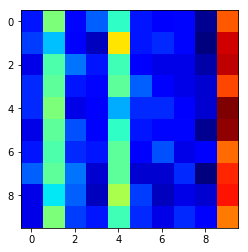

In [43]:

plt.imshow(conf_mx, cmap = "jet")
plt.show()

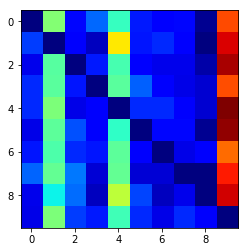

In [44]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.imshow(norm_conf_mx, cmap = "jet")
plt.show()

### Final step – evaluating on the test set

In [45]:
from sklearn.metrics import accuracy_score

sgd_rbf.fit(X_train, y_train) 
#X_test_features_scaled = scaler.fit_transform(X_test_features.astype(np.float64))
y_pred = sgd_rbf.predict(X_test)
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.8888888888888888


array([[35,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 35,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  4, 31,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 36,  0,  1,  0,  0,  0,  0],
       [ 0,  6,  0,  0, 30,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 37,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  1,  0,  1,  0,  0,  0, 34,  0,  0],
       [ 0, 15,  0,  0,  0,  2,  0,  0, 18,  0],
       [ 0,  4,  0,  0,  0,  0,  0,  2,  0, 30]])

In [46]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(precision, recall, f1)

0.9331101546309579 0.8888888888888888 0.8941795496950958


In [47]:
from sklearn.metrics import accuracy_score

ovo_clf.fit(X_train, y_train) 
#X_test_features_scaled = scaler.fit_transform(X_test_features.astype(np.float64))
y_pred = ovo_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.9555555555555556


array([[35,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 29,  0,  0,  0,  0,  0,  0,  5,  2],
       [ 0,  0, 35,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 36,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 36,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 37,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0, 34,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 36,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  1, 32,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1, 34]])

In [48]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(precision, recall, f1)

0.9569487630342894 0.9555555555555556 0.955483979541146


In [49]:
# X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.8111111111111111


array([[33,  0,  0,  0,  1,  1,  0,  0,  1,  0],
       [ 0, 29,  1,  0,  0,  0,  1,  0,  3,  2],
       [ 0,  3, 19,  0,  0,  0,  0,  0, 13,  0],
       [ 0,  0,  1, 26,  0,  0,  0,  1,  8,  1],
       [ 0,  2,  0,  0, 26,  0,  1,  6,  1,  0],
       [ 0,  0,  0,  0,  0, 35,  0,  1,  0,  1],
       [ 0,  1,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 35,  0,  0],
       [ 0,  4,  1,  0,  0,  0,  0,  1, 29,  0],
       [ 0,  3,  1,  0,  0,  0,  0,  4,  3, 25]])

In [50]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(precision, recall, f1)


0.8479871939298477 0.8111111111111111 0.8150828576150382
